# Gans (E-scooter) - Data Engineering: Pipelines on the Cloud

             

**Report Submitted by Arpana Singh**     

As a Data Engineer/Data Scientist to be, I was working on my first Data Engineering Pipeline for the last three weeks, during my Data Science Bootcamp. The objective of this project was to accomplish the following steps:

**Data Collection:**  First steps to collect the data through webscraping or Application Programming Interfaces (APIs)

**Data Storage:** And then to create a Database (MySQL in my case) and store the gathered data in MYSQL database locally

**Pipeline to the Cloud:** After that to use Amazon Web Services (AWS) to move the pipeline to the cloud

**Pipeline Automation:** And finally to automate the whole data collection and storage process

So, first of all, I will explain what we really want to do for the Gans using the data Engineering process. I am a Data Engineer at Gans, the company that rents e-scooters in different European cities and I would like to improve the business. Gans has seen that its operational success depends on having a good prediction of its e-scooters parked where users need them.
Predictive modelling is undoubtedly on the roadmap, but the first step is to collect more data. This is where you come in: your task will be to collect data from external sources that can potentially help Gans predict e-scooter movement. Since data is needed every day, in real-time and accessible by everyone in the company, the challenge will be to assemble and automate a data pipeline in the cloud.


## Data Collection

Collecting the data is the first step in my Data Engineering Pipeline. The good thing is that the internet is full of data. But it is not always easy to get the data that you need. I used three different approaches to gather my data.

First of all, Search for APIs from which I can request the data — a good starting point is RapidAPI, a hub with a massive collection of APIs and  Download from GeoNames the world cities CSV, where you can find the unique geo_nameid numbers for each country-city (world_cities.csv). For this project was created a CSV file with a sample of 15 of the most populated cities from Europe (name, country).
And after that, I search for valuable data on websites and gather it through web-scraping techniques using python and BeautifulSoup.

* Gather weather data from OpenWeatherMap API

First, let’s collect some weather data from the OpenWeatherMap API. To use this API you just need to create an account and then there are some free services, like the 3h weather forecast for the next 5 days. Using pythons requests library it is possible to directly call the api. 

``` Python

import request
from datetime import datetime
import pandas as pd
import myconfig as cfg 
requests.get
cities = cities_df['city']
API_key = cfg.WEATHER_API_KEY

weather = pd.DataFrame(columns=['city',
                                'city_id',
                                'time_utc',
                                'local_time',
                                'temperature',
                                'humidity',
                                'cloudiness_pc',
                                'wind_speed',
                                'precipitation_prob',
                                'rain_volume',
                                'snow_volume'])
                                for city in cities:
    url = f"http://api.openweathermap.org/data/2.5/forecast?q={city}&appid={API_key}&units=metric"
    response = requests.get(url)
   ```
                                

In python the equivalent data structure would be a dictionary with nested lists and dictionaries, depending on the structure of the dataset. From your response you can now get your data by accessing individual key/value pairs or by looping through the whole dataset. Finally I saved the data as a DataFrame to push it into my database in the data storage step. By the way, it is also possible to connect to the OpenWeatherMap API through RapidAPI.

**Get data for arriving flights**

The AeroDataBox API is a good way to request data about arriving flights. This API is accessible through RapidAPI, with one downside — you have only 200 API requests per month in the free subscription plan. The approach for getting the data is the same as with the weather data — request the data from the API and retrieve the needed data from the response json.

The AeroDataBox API only returns flight data for 12 hours. To get the data for a whole day, two requests in a for loop are necessary. Later, I want to automatically get the arrival data for the next day, so I used the datetime module to get the next day from the actual day.
```python

import requests
import datetime
import pandas as pd
import numpy as np
import config as cfg

cities_df = pd.read_csv('cities.csv')
cities = cities_df['city']

airports = pd.DataFrame(columns=['city','city_id','lat','lon','icao','iata','name'])


for city in cities:
    lat = float(cities_df.loc[cities_df['city']==city]['Latitud'])
    lon = float(cities_df.loc[cities_df['city']==city]['Logitud'])

    url = f"https://aerodatabox.p.rapidapi.com/airports/search/location/{lat}/{lon}/km/50/16"
    
    querystring = {"withFlightInfoOnly":"0"}
    
    headers = {
            	"X-RapidAPI-Key": cfg.RAPIDAPI_KEY,
            	"X-RapidAPI-Host": "aerodatabox.p.rapidapi.com"
            }
    
    response = requests.request("GET", url, headers=headers)#, params=querystring)
    print('Status code',response.status_code)
    airp_js = response.json()
    
    for a in airp_js["items"]:
        airports = airports.append({'city':city,
                      'city_id': cities_df[cities_df['city']==city].city_id.iloc[0],
                      'lat':a["location"]["lat"],
                      'lon':a["location"]["lon"],
                      'icao':a["icao"],
                      'iata':a["iata"],
                      'name':a["name"]
                      }
                      ,ignore_index=True)

        
airports.to_csv('airports_new.csv', index=False)
```

**Collect Data from the Web through webscraping**

If you can’t find an API that can provide the data you need another way is to scrape
the data from a webpage. In my case I first tried to get some population data for the 
cities in which gans operates.

The python library BeautifulSoup in combination with the requests library makes it easy 
to get the data from each html element of the website. You only need to inspect the webpage 
and find the html tags that contains your wanted data.

**For one city the population data can be collected with the following script.**

```python

import geocoder
import pandas as pd

wc = pd.read_csv('world_cities.csv')
countries= pd.read_csv('EuroCitiesPopulation15_.csv').country
cities = pd.read_csv('EuroCitiesPopulation15_.csv').name

city_id=[]
for co,ci in zip(countries,cities):
    city_id=city_id+[(wc.set_index('country').loc[co].set_index('name').loc[ci].geonameid)]
    
    
lat=[]
lng=[]
population=[]
country_code=[]
time_zone=[]
east=[]
south=[]
north=[]
west=[]

for c in city_id:

    # DATA COLLECTION:

    g = geocoder.geonames(c, method='details', key='jlma_ve84')
    lat             = lat+[(g.geojson['features'][0]['properties']['lat'])]
    lng             = lng+[(g.geojson['features'][0]['properties']['lng'])]
    population      = population+[(g.geojson['features'][0]['properties']['population'])]
    country_code    = country_code+[(g.geojson['features'][0]['properties']['country_code'])]
    time_zone       = time_zone+[3600*(g.geojson['features'][0]['properties']['raw']['timezone']['gmtOffset'])]
    east            = east+[(g.geojson['features'][0]['properties']['raw']['bbox']['east'])]
    south           = south+[(g.geojson['features'][0]['properties']['raw']['bbox']['south'])]
    north           = north+[(g.geojson['features'][0]['properties']['raw']['bbox']['north'])]
    west            = west+[(g.geojson['features'][0]['properties']['raw']['bbox']['west'])]  
    
cities_dic = {'city_id': city_id,
              'city': cities, 
              'country':countries, 
              'Code': country_code, 
              'Population': population, 
              'Time_Zone': time_zone,
              'Latitud': lat, 
              'Logitud': lng, 
              'East': east, 
              'South': south, 
              'North': north, 
              'West': west}
cities_df  = pd.DataFrame.from_dict(cities_dic)
cities_df.to_csv('cities.csv', index=False) 


```

## Create a database model on the AWS cloud for MySQL instance

### Storing Data in a MySQL Database ###
Now that I have gathered all my data locally in some python scripts I want to save the data in a database. This will enable me to run the scripts again and again with new dates or new citys to gather more and more data. And I will be able to query my database and analyse the data.

In MySQL Workbench I run a sql script to create a database with all the necessary tables to store my data. In this step I also need to define the datatypes of the different columns. I basically used varchar(255) for text values and double for numbers. This was especially important for the latitude and longitude to write the exact numbers into the databse and not by mistake round them, when for example using the decimal datatype.

I ended up with this database schema.The primary keys are indicated by the yellow symbols. Foreign keys are indicated by the pink diamonds. Every foreign key is a primary key of another table.

In [3]:
Image(url="Schema.jpg", width=1794, height=879)

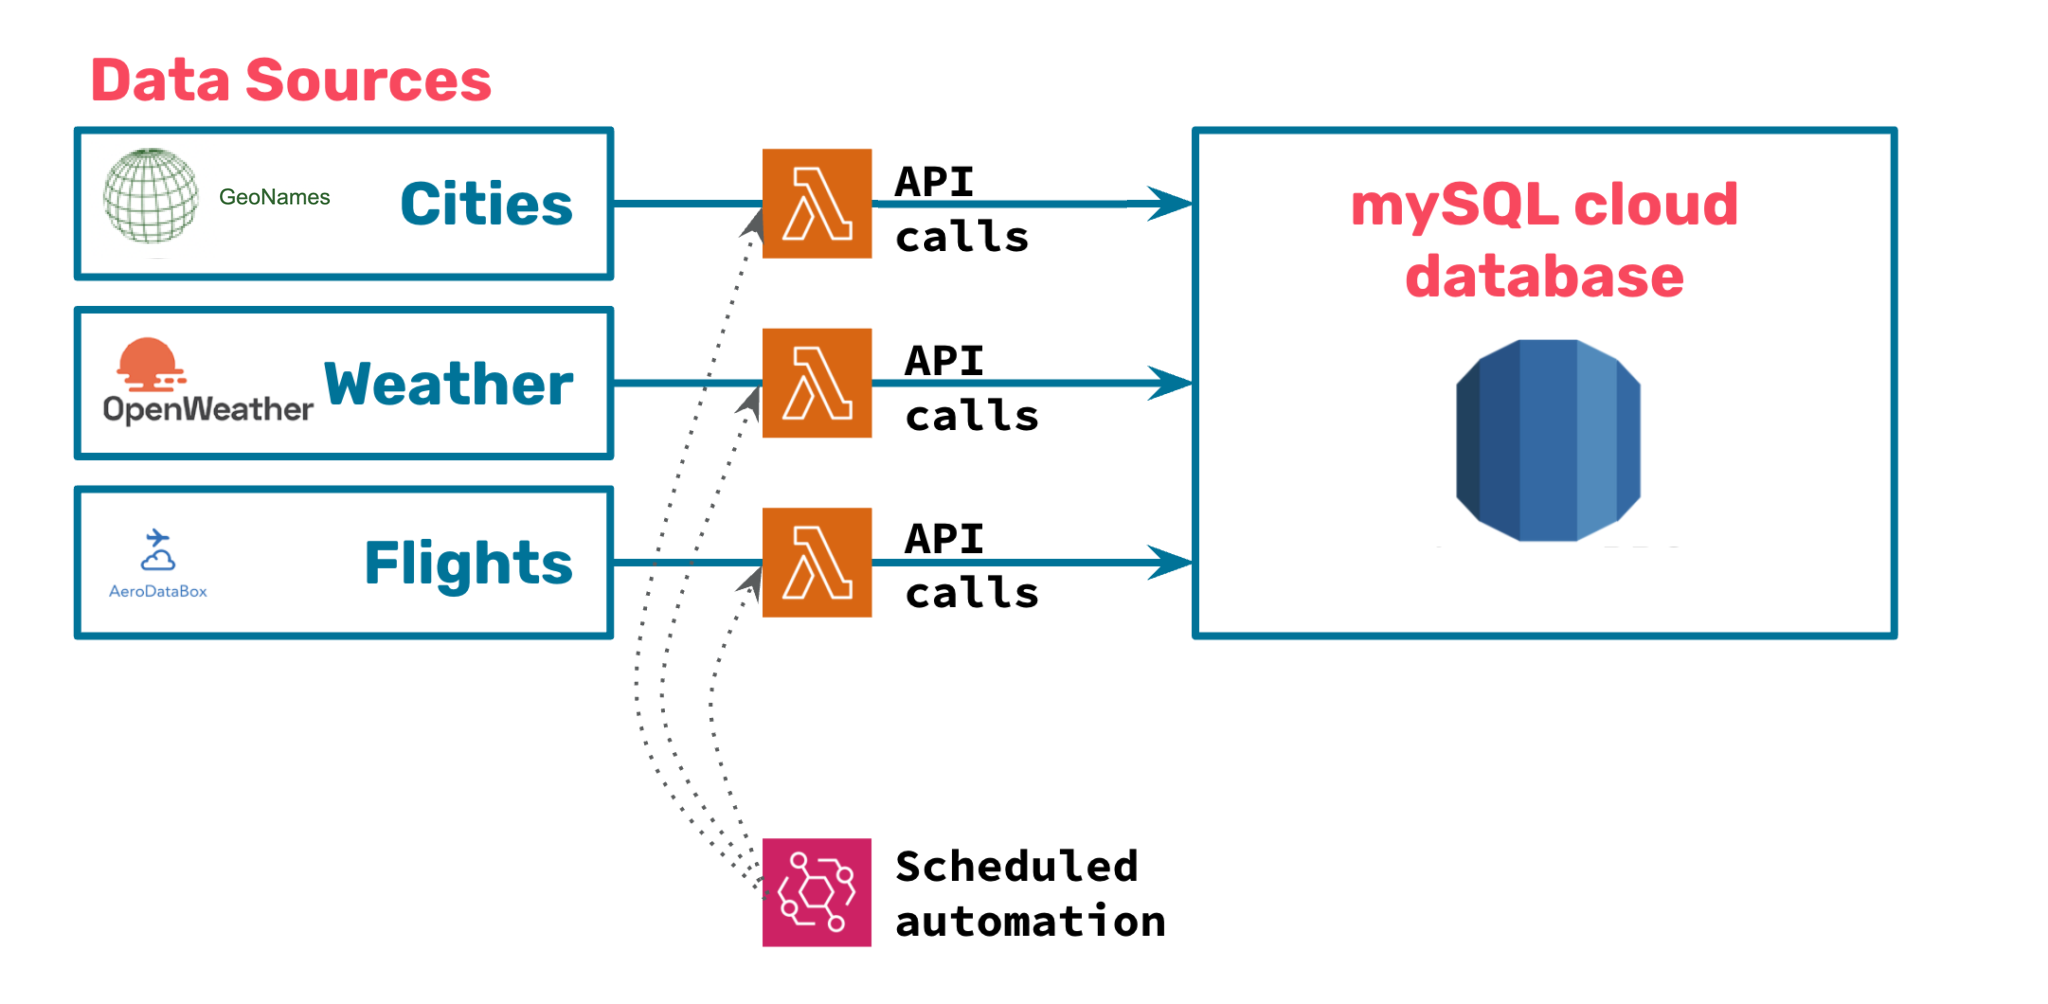

In [1]:
from IPython.display import Image
Image(filename='data_pipeline.png',width=800, height=400)

To get the data into the database python provides another useful library SQLAlchemy.
There you establish a connection to you local database and just send your dataframe 
to the database. Here I send the weather data to the database. To do this I first need to
convert the column with the date weather_datetime to the datatype datetime to have the correct
input datatype for my database, where I also specified the datatype for this column as datetime.

### Pre-requirements:

1) Create AWS cloud account active
2) Create a Amazon Relational Database Service (AWS RDS) MySQL instance.

### To setup the MySQL  

``` mysql

CREATE DATABASE gans;
USE gans;


CREATE TABLE IF NOT EXISTS cities (
	city_id INT,
    city VARCHAR(200),
    country VARCHAR(200),
    country_code CHAR(2),
    population INT,
    time_zone INT,
    latitude FLOAT,
    longitude FLOAT,
   	PRIMARY KEY(city_id)
);

SELECT * FROM cities;


CREATE TABLE IF NOT EXISTS weathers (
	weather_id INT auto_increment,
    city_id INT,
    time_utc INT,
    local_time CHAR(20),
    temperature FLOAT,
    humidity FLOAT,
    cloudiness_pc INT,
    wind_speed FLOAT,
    precipitation_prob FLOAT,
    rain_volume FLOAT,
    snow_volume FLOAT,
    PRIMARY KEY(weather_id),
    FOREIGN KEY(city_id) REFERENCES cities(city_id)
);

SELECT * FROM weathers;



CREATE TABLE IF NOT EXISTS airports (
	city_id INT,
    lat FLOAT,
    lon FLOAT,
    icao CHAR(4),
    iata CHAR(3),
    name VARCHAR(200),
    PRIMARY KEY(icao),
    FOREIGN KEY(city_id) REFERENCES cities(city_id)
);

SELECT * FROM airports;




CREATE TABLE IF NOT EXISTS flights (
	flights_id INT auto_increment,
    icao CHAR(4),
    date CHAR(10),
    hour_day CHAR(5),
    num_of_arriv INT,
    num_of_depart INT,
    PRIMARY KEY(flights_id),
    FOREIGN KEY(icao) REFERENCES airports(icao)
);

SELECT * FROM flights;
```

 I have collected the data and have a database running from which I can query the data. I could now also automate the process locally but the smarter way is to push the whole process to the cloud to not have my own pc running all the time.

## AWS Lambda automation data collection

In [2]:
from IPython.display import Image

**Pipeline Automation:**

automate the whole data collection and storage process

  In this project, I use Amazon Web Services (AWS) as a service provider for cloud computing. Starting my adventure in the cloud is straightforward with creating an account that comes with some free services for the first
12 months. Using the documentation helps to make the database instance easily. Write down your password and copy the database endpoint as you will need this to connect to your database from your scripts.
    
After that next step, we used MYSQL Workbench to create a new database in my cloud RDS instance with the
same script we used for my local database. I will use another AWS service — Lambda functions to fill my cloud database with my gathered data. To give the lambda functions access to the RDS service 
I first need to create a new Role in the AWS Identity and Access Management (IAM).

Now, I just need to transfer my data collection scripts from my jupyter notebook to one or more
lambda functions.Having one lambda function for weather data and flights data will make it easier to
automate the data collection process at the end. Within the lambda function you need to make sure that your main code is in the provided lamdba handler function `def lamdbda_handler(event, context):`

Then create a test event to test your function. When requesting data from an API sometimes a timeout error occurs and you should configure the timeout settings for the function to something bigger than 3 seconds (the default value). When everything runs fine you will see something like this as response.

<img src="Lambda_function_excution.png" width="1794" height="879"

In [11]:
Image(url="Lambda_function_excution.jpg", width=1794, height=879)
#fig.caption: Response “null”, no error, lamdba function run as expected

As we did not specify any output for my lamdba function — it just send the data to the database — we get “null” as response and we know that everything is fine. In MySQL workbench we can query the database, get the results and also see that my data is there.

In [13]:
Image(url="MYSQL_weather.jpg", width=500, height=300)
#Figure_caption:The data can be queried from the rds cloud database through MySQL workbench.

### **Automate the Data Engineering Pipeline** ###

So far we did the same locally and in the cloud — creating a database, collecting some data and saving it
in the database. Some added value now comes from the possibility to easily create event triggers that
automate the lamdba functions. This can be done in AWS Cloud/AWS EventBridge. Using Cron expressions
it is quite easy to create rules when your lamdba function should be executed.

In [14]:
Image(url="Timetrigger.jpg", width=500, height=300)


figure caption: The cron expression to run the lambda function every day at 24 o’clock GMT.

Because we run the weather and flight lambda function, that collects the 3h forecast for 5 days, every day we will get lotb of duplicated data entries in my database. But I always want to have the latest weather data for a specific date and thus I will need to remove the duplicated items afterwards when analysing the data.

## **Project Summary** ##

Now that we have an automated Data Engineering Pipeline running in the Cloud we will have a 
look at the flaws of this project and some future tasks.

### **Data collection through web scraping.**
* **Go for an API,** that offers the data that you need, whenever you find one. In a real company there might even be some budget for the ones that are not free to use or only allow limited requests.

* **The AWS universe** offers such a huge amount of services and we only touched a very small fraction. However the tools we used served very well for the purpose of implementing an automated data engineering pipeline in the cloud.

* **As my lamdba functions** run automatically now I just need to check from time to time whether errors occur or maybe implement an email for this task.

* **Now that the weather predictions** for the following five days, plus the flight arrivals and departure details date per hour, is available in the database and updated daily, in real-time and accessible by everyone in the company. It will be easy to analyse and predict some valuable insights from it for the Gans.
